In [1]:
import requests
from os.path import basename

def download(url):
    response = requests.get(url)
    if response:
        file_name = basename(url)
        out = open(file_name,'w',encoding='utf-8')
        out.write(response.text)
        out.close()
        
def find_title(file_name):
    title = basename(file_name)
    title = re.sub('.txt$','',title)
    return title
        
download('https://raw.githubusercontent.com/peterverhaar/dmt-2024/refs/heads/main/Assignment3/text_mining.py')


In [2]:
import requests
import re
import os
import string
string.punctuation += '-•“”’– '
from text_mining import *

from os.path import join

from nltk import word_tokenize,sent_tokenize,pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

stopwords = stopwords.words('english')

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
ana = SentimentIntensityAnalyzer()


In [3]:
directory = 'Corpus'
corpus = os.listdir(directory)
corpus = [os.path.join(directory,text) for text in corpus if re.search(r'txt$',text) and not(re.search(r'lemma',text))]

for text in corpus:
    print(text)
    
metadata = pd.read_csv('metadata.csv')

Corpus/mansfield_park.txt
Corpus/sense_and_sensibility.txt
Corpus/oliver_twist.txt
Corpus/david_copperfield.txt
Corpus/hard_times.txt
Corpus/northanger_abbey.txt
Corpus/persuasion.txt
Corpus/emma.txt
Corpus/the_pickwick_papers.txt
Corpus/a_tale_of_two_cities.txt


## Linguistic features

For each text, the number of characters, the number of words and the number of sentences are calculated. Using these data, we can compare the avarage word lengths and the average sentence lengths of all the novels. 

In [4]:
data = []

for file in corpus:
    print(f'Analysing {file} ... ')
    row = []
    text = open(file,encoding='utf-8')
    full_text = text.read()
    
    # Calculate number of characters (without spaces)
    full_text_no_spaces = re.sub( r'\s','',full_text)
    nr_characters = len(full_text)
    
    # Calculate number of words
    words = word_tokenize(full_text.lower())
    words = remove_punctuation(words)
    nr_tokens = len(words)
    
    avg_word_length = nr_characters / nr_tokens
    
    row.append(nr_tokens)
    row.append(nr_characters)
    row.append(avg_word_length)
    
    sentences = sent_tokenize(full_text)
    nr_sentences = len(sentences)
    row.append(nr_sentences)
    avg_sent_length = nr_tokens/nr_sentences
    
    row.append(avg_sent_length)
    
    first_2000 = words[:2000]
    unique = list(set(first_2000))
    ttr = len(unique)/len(first_2000)
    row.append(ttr)
    
    row.append(find_title(file))
    category = metadata.query( f"text=='{find_title(file)}' " )['category'].values[0]
    row.append(category)
    data.append(row)
    
columns = ['nr_tokens','nr_characters','word_length','nr_sentences','words_per_sentence','ttr','title','category']
df = pd.DataFrame(data, columns = columns)

Analysing Corpus/mansfield_park.txt ... 
Analysing Corpus/sense_and_sensibility.txt ... 
Analysing Corpus/oliver_twist.txt ... 
Analysing Corpus/david_copperfield.txt ... 
Analysing Corpus/hard_times.txt ... 
Analysing Corpus/northanger_abbey.txt ... 
Analysing Corpus/persuasion.txt ... 
Analysing Corpus/emma.txt ... 
Analysing Corpus/the_pickwick_papers.txt ... 
Analysing Corpus/a_tale_of_two_cities.txt ... 


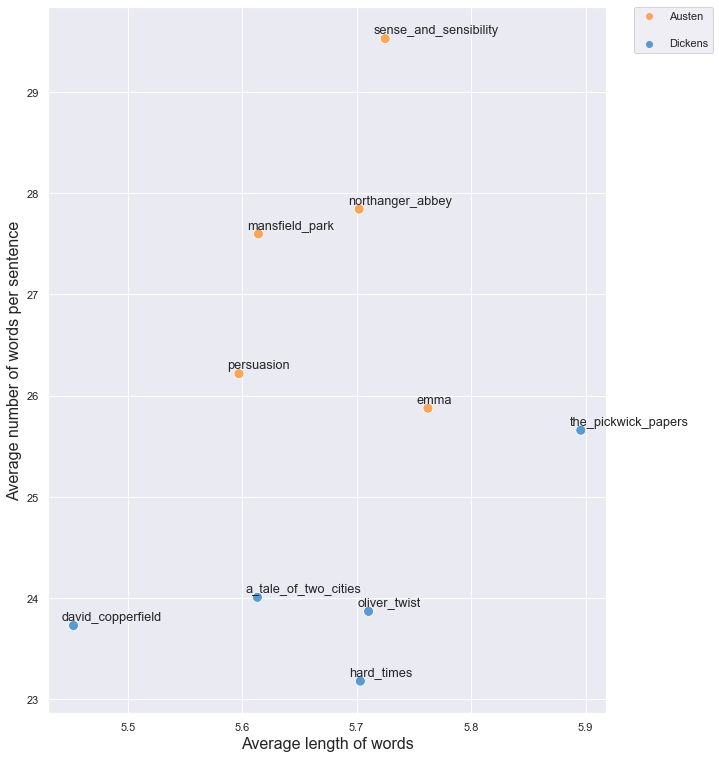

In [5]:
x_axis = 'word_length'
y_axis =  'words_per_sentence'
hue = 'category'

colours = ['#f9a65a','#599ad3']

fig = plt.figure( figsize = ( 10,13 ))

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df, x=x_axis, y=y_axis,  
                     hue = hue,  palette=colours ,  s=100 )

for index, row in df.iterrows():
    plt.text( row[x_axis]-0.01, row[y_axis]+0.05 , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Average length of words'  , fontsize = 16 )
ax.set_ylabel( 'Average number of words per sentence'  , fontsize = 16 )
#ax.set_title( '' , fontsize=24 )
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.savefig( 'scatterplot.png' , dpi=300 )

## Type-token ratio

The type-token ratio can be calculated by dividing the number of unique words (the types) by the total number of words (the tokens). The number gives [an indication of the lexical diversity](https://cdsleiden.github.io/tdm-tutorial/notebooks/5%20Type-token_ratio.html). 

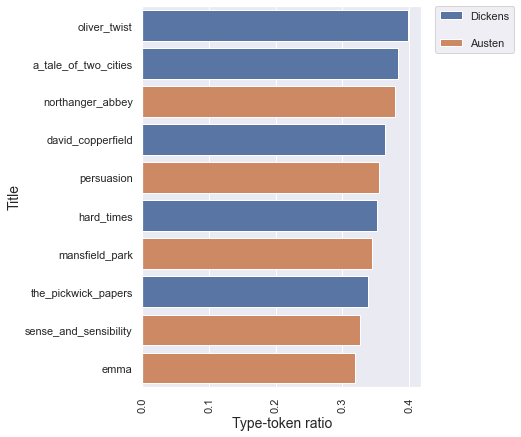

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

x_axis = 'ttr'
y_axis = 'title'
hue = 'category'

colours = ['#599ad3','#f9a65a']

fig = plt.figure( figsize=( 5,7 ) )

df_sorted = df.sort_values(by=[ x_axis] , ascending = False)

graph = sns.barplot( data=df_sorted , x=x_axis, y=y_axis, 
                   hue = hue , dodge = False)

#graph.set_title('' , size = 20) 
graph.set_xlabel('Type-token ratio' , size = 14) 
graph.set_ylabel('Title' , size = 14 )

plt.xticks(rotation= 90)

plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

## Part of Speech tagging and Lemmatisation

In [7]:
def clean_wordlist(words):
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stopwords]
    words = [re.sub(r'([….])|(\')','',word) for word in words]
    words = [word for word in words if re.search(r'\w', word)]
    return words

data = []
all_novels = []
lemmatiser = WordNetLemmatizer()

# Dictionaries to save all nouns, adjectives, adverbs and nouns 
all_adj_adv_noun = dict()
all_verbs = dict()

adj_noun_pos = ['JJ','JJR','RB','RDR','RBS','NN','NNS','NNP']
verbs_pos = ['VB','VBD','VBG','VBN']

# Dictionary to save number of tokens
nr_tokens = dict()

for file in corpus:
    lemmatised = ''
    pos_tags = dict()

    # Pos categories in the current text
    adj_adv_noun = []
    verbs = []
    
    count_tokens = 0
    
    out_file = re.sub( r'\.txt$' , '_lemma.txt', file)
    
    print(f'Analysing {file} ... ')

    text = open(file,encoding='utf-8')
    full_text = text.read()
    sentences = sent_tokenize(full_text)
    
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = clean_wordlist(words)
        pos = pos_tag(words)

        for i,word in enumerate(words):
            word = word.lower()

            pos_tags[pos[i][1]] = pos_tags.get(pos[i][1],0)+1
                       
            posTag = ptb_to_wordnet( pos[i][1] )
            if re.search( r'\w+' , posTag , re.IGNORECASE ):
                lemma = lemmatiser.lemmatize( words[i] , posTag )
                lemmatised += lemma + ' '
                count_tokens += 1
                
                if len(lemma)>0:
                
                    if pos[i][1] in adj_noun_pos:
                        adj_adv_noun.append(lemma.lower())
                    if pos[i][1] in verbs_pos:
                        verbs.append(lemma.lower())

        lemmatised += '\n'
    
    all_adj_adv_noun[file] = adj_adv_noun
    all_verbs[file] = verbs
    nr_tokens[file] = count_tokens
    all_novels.append(file)
        
    with open(out_file,'w',encoding='utf-8') as out:
        out.write(lemmatised)
        
    
    total = sum(pos_tags.values())
    row = []
    row.append(find_title(file))
    category = metadata.query( f"text=='{find_title(file)}' " )['category'].values[0]
    row.append(category)
    row.append(pos_tags.get('MD',0)/total)
    row.append(pos_tags.get('FW',0)/total)
    row.append(pos_tags.get('JJ',0)/total)
    row.append((pos_tags.get('JJR',0)+pos_tags.get('JJS',0))/total)
    row.append(pos_tags.get('RB',0)/total)
    row.append((pos_tags.get('RBR',0)+pos_tags.get('RBS',0))/total)
    data.append(row)

df_pos = pd.DataFrame(data,columns=['title','category','modal_verb','foreign_word','adj','adj-comp-super','adv','adv-comp-super'])


Analysing Corpus/mansfield_park.txt ... 
Analysing Corpus/sense_and_sensibility.txt ... 
Analysing Corpus/oliver_twist.txt ... 
Analysing Corpus/david_copperfield.txt ... 
Analysing Corpus/hard_times.txt ... 
Analysing Corpus/northanger_abbey.txt ... 
Analysing Corpus/persuasion.txt ... 
Analysing Corpus/emma.txt ... 
Analysing Corpus/the_pickwick_papers.txt ... 
Analysing Corpus/a_tale_of_two_cities.txt ... 


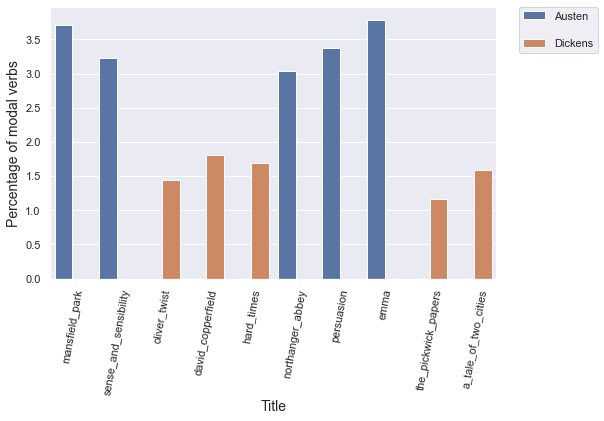

In [8]:
df_pos['modal_verb'] = df_pos['modal_verb']*100

fig = plt.figure( figsize=( 8,5 ) )


graph = sns.barplot( data=df_pos,x='title', y='modal_verb', 
                   hue = 'category')

#graph.set_title('' , size = 20) 
graph.set_xlabel('Title' , size = 14) 
graph.set_ylabel('Percentage of modal verbs' , size = 14 )

plt.xticks(rotation=80)
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

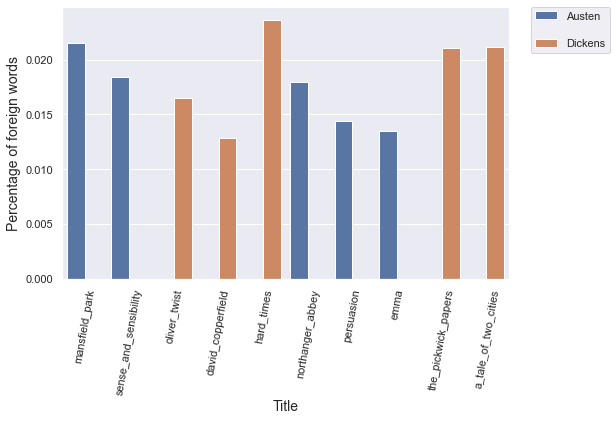

In [9]:
df_pos['foreign_word'] = df_pos['foreign_word']*100

fig = plt.figure( figsize=( 8,5 ) )


graph = sns.barplot( data=df_pos,x='title', y='foreign_word', 
                    hue = 'category' )

#graph.set_title('' , size = 20) 
graph.set_xlabel('Title' , size = 14) 
graph.set_ylabel('Percentage of foreign words' , size = 14 )

plt.xticks(rotation=80)
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

In [10]:
df_pos['adj-comp-super'] = df_pos['adj-comp-super']*100
df_pos['adj'] = df_pos['adj']*100
df_pos['adv-comp-super'] = df_pos['adv-comp-super']*100
df_pos['adv'] = df_pos['adv']*100

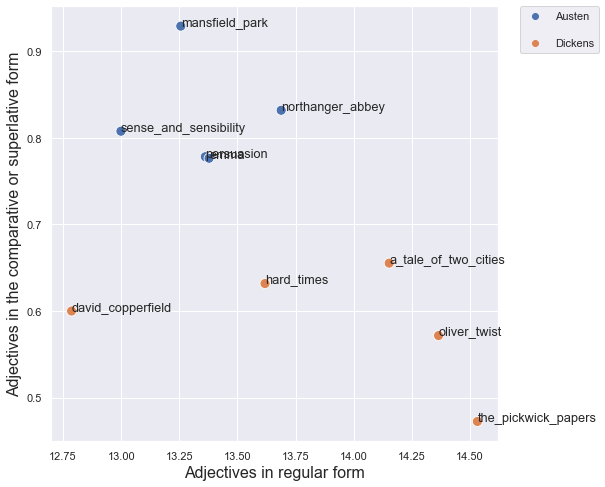

In [11]:
fig = plt.figure( figsize = ( 8,8 ))

x_axis='adj'
y_axis='adj-comp-super'

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df_pos, x=x_axis, y=y_axis,  
                     hue = 'category',  s=100 )

for index, row in df_pos.iterrows():
    plt.text( row[x_axis], row[y_axis], row['title'] , fontsize=12.8)

ax.set_xlabel( 'Adjectives in regular form'  , fontsize = 16 )
ax.set_ylabel( 'Adjectives in the comparative or superlative form'  , fontsize = 16 )
#ax.set_title( '' , fontsize=24 )
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

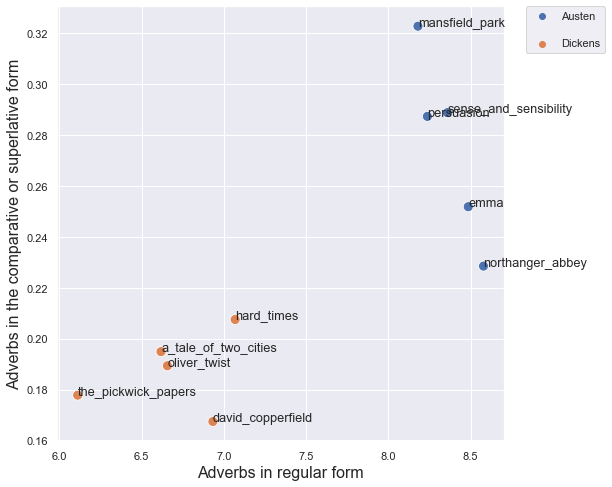

In [12]:
fig = plt.figure( figsize = ( 8,8 ))

x_axis='adv'
y_axis='adv-comp-super'

## This line adds spacing in between the lines of the legend 
sns.set(rc = {'legend.labelspacing': 1.6})

ax = sns.scatterplot( data=df_pos, x=x_axis, y=y_axis,  
                     hue='category',  s=100 )

for index, row in df_pos.iterrows():
    plt.text( row[x_axis], row[y_axis] , row['title'] , fontsize=12.8)


ax.set_xlabel( 'Adverbs in regular form'  , fontsize = 16 )
ax.set_ylabel( 'Adverbs in the comparative or superlative form'  , fontsize = 16 )
#ax.set_title( '' , fontsize=24 )
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);
plt.show()

## Most frequent words

The words have been lemmatised first.

In [13]:
for file in os.listdir(directory):
    if re.search( 'lemma.txt',file ):
        path = os.path.join(directory,file)
        with open(path,encoding='utf') as fh:
            full_text = fh.read()
            words = word_tokenize(full_text.lower())
            # stopwords and punctuation is removed
            words = clean_wordlist(words)
            freq = Counter(words)
            key = re.sub('_lemma','',path)
            print(f"\n{find_title(key)}\n")
            for word,count in freq.most_common(15):
                print(f'{word} ({count})')



oliver_twist

say (1472)
mr (1077)
oliver (861)
look (463)
old (455)
come (447)
reply (423)
know (415)
bumble (396)
take (389)
man (387)
go (378)
make (372)
time (371)
gentleman (366)

sense_and_sensibility

elinor (679)
say (600)
marianne (562)
mrs (526)
know (367)
think (327)
sister (315)
make (304)
much (290)
give (286)
see (268)
time (257)
edward (256)
well (255)
dashwood (249)

emma

mr (1117)
say (857)
emma (826)
mrs (681)
think (643)
miss (591)
know (505)
harriet (481)
much (473)
thing (448)
well (433)
weston (432)
make (409)
come (389)
elton (383)

hard_times

say (938)
mr (654)
bounderby (535)
know (425)
mrs (388)
go (387)
come (323)
gradgrind (312)
sparsit (294)
make (274)
look (271)
louisa (265)
take (239)
sir (233)
see (231)

northanger_abbey

catherine (485)
say (324)
think (242)
go (233)
tilney (218)
know (208)
miss (206)
well (186)
make (179)
mrs (175)
much (169)
time (160)
mr (160)
never (158)
general (154)

the_pickwick_papers

mr (5747)
say (3982)
pickwick (2372)
sir

## Unique words

In [14]:
categories = list(metadata['category'].unique())

corpus1 = []
corpus2 = []
corpus1_freq = Counter()
corpus2_freq = Counter()

for text in corpus:
    category = metadata.query( f"text=='{find_title(text)}' " )['category'].values[0]
    if category == categories[0]:
        corpus1.append(text)
    else:
        corpus2.append(text)

for text in corpus1:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    corpus1_freq.update(words)

    
for text in corpus2:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    corpus2_freq.update(words)

In [15]:
print(f'The list below indicates the 20 most frequent words in the {categories[0]} subcorpus.\n')

for word,count in corpus1_freq.most_common(20):
    print(f'{word} => {count}')

The list below indicates the 20 most frequent words in the Austen subcorpus.

could => 3061
would => 2751
must => 1749
said => 1603
much => 1581
miss => 1550
one => 1549
every => 1239
think => 1221
might => 1165
well => 1135
never => 1118
little => 1096
time => 1081
know => 1059
good => 1008
fanny => 963
nothing => 959
without => 871
say => 864


In [16]:
print(f'The list below indicates the 20 most frequent words in the {categories[1]} subcorpus.\n')

for word,count in corpus2_freq.most_common(20):
    print(f'{word} => {count}')

The list below indicates the 20 most frequent words in the Dickens subcorpus.

said => 8883
one => 2828
would => 2559
little => 2482
upon => 2464
pickwick => 2352
old => 2308
sir => 2257
man => 2213
could => 2026
know => 2012
time => 1878
replied => 1713
never => 1621
say => 1570
much => 1540
well => 1522
come => 1500
good => 1479
see => 1452


In [17]:
print(f'The following words from the {categories[0]} subcorpus are NEVER used in the {categories[1]} subcorpus\n')

for word,count in corpus1_freq.most_common():
    if word not in corpus2_freq.keys():
        print(word)

The following words from the Austen subcorpus are NEVER used in the Dickens subcorpus

fanny
elinor
crawford
marianne
catherine
harriet
weston
elton
knightley
woodhouse
elliot
bertram
dashwood
jennings
fairfax
wentworth
tilney
rushworth
churchill
willoughby
norris
mansfield
hartfield
thorpe
morland
brandon
walter
musgrove
ferrars
highbury
middleton
barton
cousins
randalls
palmer
eleanor
harville
uppercross
perry
kellynch
yates
lyme
benwick
goddard
croft
sotherton
norland
shew
campbell
portsmouth
donwell
chuse
frederick
taylor
musgroves
hayter
shewed
steele
northanger
dashwoods
bertrams
wallis
enscombe
surprize
shewn
steeles
surprized
maple
dalrymple
delaford
fullerton
cleveland
crofts
campbells
thornton
rebecca
eltons
stopt
woodston
shewing
tilneys
weymouth
middletons
charade
mortifying
allenham
udolpho
harvilles
baronet
curricle
agatha
hawkins
lacey
ireland
complaisance
exeter
combe
morton
harley
milsom
hughes
crawfords
everingham
anhalt
pulteney
vicarage
amelia
enquiries
cobb
northam

turnings
romancing
circumventing
manœuvres
opposer
favourer
disingenuous
inhumanity
incumbrances
recoverable
unperplexed
embargo
complicate
subtleties
forwardness
dimming
streightens
wriggles
superiorities
assorting
captiously
inadvertencies
misconstructions
recomposed
broodings
sultaness
granting
proverbs
calculates
undeviating
prophesied
gunsmith
repulsively
politicians
retrospections
retarding
governance
darings
felicitous
inaction
eligibilities
corrective
landaulette
headship
wheedled
transgressions
accessions
valetudinarian
bangs
broadway
drizzle
adoption
dissentient
quicksighted
chilblains
prosings
creditably
scalloped
custard
appreciating
alderneys
wool
yeomanry
8th
fluctuations
unmodulated
engrosses
bluntness
sufferable
alphabetically
inherits
wantonness
foretelling
flatterer
errs
portfolio
miniatures
crayon
featured
forswear
fidgeting
stationing
encourager
commissions
grammatical
demurs
diffuses
gossips
waiving
misapply
bewitches
clayton
transcribing
ciphers
trophies
enigmas
c

In [18]:
print(f'The following words from the {categories[1]} subcorpus are NEVER used in the {categories[0]} subcorpus\n')

for word,count in corpus2_freq.most_common():
    if word not in corpus1_freq.keys():
        print(word)

The following words from the Dickens subcorpus are NEVER used in the Austen subcorpus

pickwick
weller
micawber
peggotty
winkle
bounderby
copperfield
traddles
dora
agnes
steerforth
bumble
lorry
sikes
wery
murdstone
gradgrind
fagin
defarge
sparsit
bob
wardle
sawyer
uriah
snodgrass
perker
ly
wickfield
wot
pott
bardell
brownlow
davy
rachael
sammy
jingle
pross
heep
manette
barkis
eh
carton
trotwood
spenlow
sissy
darnay
noah
monks
harthouse
fogg
lucie
gen
creakle
r
cruncher
giles
mas
dodson
samuel
omer
monsieur
dodger
ben
wos
afore
serjeant
gummidge
mills
monseigneur
stryver
coketown
arabella
jerry
jip
beadle
maylie
charley
crupp
pell
tellson
trotter
punch
chin
commons
sowerberry
dartle
fur
annie
magnus
stiggins
wooden
nupkins
yer
remarked
david
jury
vith
jack
pound
wi
sydney
retorted
doen
desk
thee
dowler
chillip
jacques
paris
umble
bitzer
grimwig
arter
rubbing
th
twist
mell
benjamin
lobbs
lowten
raddle
corney
matron
sleary
thrust
bag
toby
spinster
mowcher
eatanswill
cluppins
maldon
theer


curiousity
sprightly
ludicrous
slapping
models
splashing
policeman
causing
imprecations
blazes
shaggy
smiting
agonised
screwing
inmost
postponed
ado
untying
marched
shrouded
chaps
lagged
colourless
backing
bah
timely
perished
doorways
alleys
skinny
glassful
crowbar
hugged
kid
implements
paroxysm
mingling
countrymen
smoky
pistols
howled
cask
bashfully
distorted
yell
nance
pickpocket
intoxicated
grinding
boughs
commotion
reclined
odour
appeals
originate
patronising
inhuman
vindictive
climb
nooks
pocketed
dew
pending
sultry
transfixed
bustled
snore
steaming
shattered
piles
cadaverous
snap
explosion
scoundrels
obstinately
toss
middlesex
hampstead
infallible
sidelong
gleaming
hoofs
stifled
baffled
overwhelming
withering
hammering
rocking
twopence
incompatibility
inquiringly
vegetable
natives
threshold
trotting
fishermen
curtseyed
uncompromising
magnanimous
slate
conversational
hopping
majority
chubby
flattened
culprit
contemplative
institution
joker
throne
shrimps
dooty
similarly
strife
bou

kindling
servility
contrasting
awry
triumphed
gallon
inflammation
champagne
vestry
equipages
drama
licked
childishly
fairyland
veterinary
quadrupeds
sloppy
decomposition
copies
particle
discourage
remunerative
perfidy
rebellion
decrees
posterity
ketchup
batch
deduce
sagely
discount
masculine
quote
tafflin
vacated
bacchanalian
upshot
airily
phraseology
flickering
consume
trustful
puffs
limit
sow
alongside
legatee
executrix
floundering
chip
littlest
chay
foundered
fagging
whipped
branded
beefsteak
lull
radiance
constraining
holder
pernicious
celestial
pitted
howbeit
fountains
oasis
grape
patriarch
discouraging
dirge
dishonourable
betrothal
appointing
pitfalls
pitchers
siege
exacting
tottenham
conflagration
compounding
chivalrous
soonest
idiosyncrasy
appy
leering
repairs
mastery
provincial
brew
superstitious
boastfully
judicial
bumpers
legitimate
graminivorous
supremely
insanely
bandit
horrified
nerved
frugal
plank
expounded
bower
speakers
pitt
denunciations
chemists
bribe
commits
testame

hangin
outlet
isolated
andsome
willainy
drollery
indicates
belligerent
bullets
obsequious
duelling
chambermaids
unsoaped
aloe
supernaturally
liege
assassination
concurred
talkin
impostors
baffles
lombard
simmering
oven
thump
melodiously
inconwenience
spec
manifestation
obligin
eulogistic
hearin
strait
farden
wotes
wictims
surwive
muffle
properiator
adopting
portmanteaus
precipitated
weaving
network
granddaughter
uproarious
incited
thereto
morsels
rebuke
fiddlers
jocosely
desisting
bakers
digestion
carol
scatters
jot
emblems
consorted
smelled
courtiers
goblet
atween
skate
reel
currently
bubbled
cracking
ourself
inferences
exhalations
rim
cabalistic
subpoena
nal
affectin
refresher
merrikins
turnin
watty
subpoenaed
sanctum
forensic
frownings
jobbing
revenues
tapper
parding
fierceness
ruffinly
slasher
croup
pacifically
luckless
drover
cads
wending
leadenhall
cannibal
valentine
squared
recline
constructing
actiwally
circumscribed
callin
fabulous
downhill
monthly
indefatigably
progenitor
pen

lifeboat
manned
capstan
seaman
bulged
anticipative
shoreward
stilled
pampering
punctilious
relentless
reaps
malign
penetrates
buccaneering
caulked
guernsey
shaggiest
ingredients
yarn
porpoises
dolphins
starboard
larboard
alow
sapling
attains
coffers
clime
repudiating
embarkation
partings
ostade
bulks
ringbolts
windsail
hatchway
households
stools
ploughmen
tween
unsettlement
spar
cathedrals
solitudes
precipices
bases
gorge
stemming
avalanche
steeps
betrayal
contentions
frivolously
shadowing
quicksands
bricklayer
insalubrity
prescriptive
wainscoted
indomitable
rumpling
maddest
gratifies
cockboat
improvise
doe
dem
jipes
versus
wigziell
insatiably
endowment
defaulter
exactions
pounce
hoary
inaptly
claimants
tepid
grappled
tucks
bereavement
placidest
waived
phrenological
developments
slowest
miscall
potations
lunacy
unman
terrify
wedlock
tramps
briar
harmoniously
jarred
dislikings
entreatingly
betides
inexplicably
soundest
sooty
housewife
blunting
sleet
folios
averring
enjoyingly
capped
jew

legislature
eighteenpenny
recapturing
antagonists
adversaries
clump
swings
glover
dexter
aspirating
jewess
coveted
betaken
svear
prewailance
veeds
sangvinary
unpacking
spake
chock
nib
paring
bruising
winegar
bulldog
chaunter
overbalancing
diurnally
jean
mattresses
expletive
substantive
filthily
nozzles
prongs
bender
chums
adjourning
covenanted
soldered
imports
unblotted
flicking
slipper
encourages
steeplechase
stud
overwalking
spike
shipwrecks
miscellany
duplicates
twitches
unsuspicion
snowstorm
ventilated
steams
houndsditch
beards
munch
dedicated
seediness
crispness
curiosities
opulent
jewish
omnibus
residences
chameleon
tweak
respired
pursed
horsing
freemasonry
erd
threepenn
remarkin
mace
rescuer
werdicks
learnedly
rattlin
marchioness
gradivally
subsekent
imbibes
succinctly
nixon
sixpenny
dressin
arrestin
sendin
wagabone
octavo
ledger
whiplashes
reachin
unconstitootional
blessedest
visperin
offensively
singin
metre
bess
gallops
bul
gul
likin
flank
spiteful
windictive
unremorseful
sho

## Dunning’s log likelihood

One of statistical methods that can be used to find such distinctive words is Dunning’s log likelihood. In short, it analyses the distinctiveness of word in one set of texts compared to the texts in a reference corpus, by calculating probabilities based on word frequencies. A good explanation of the fomula can be found on the [wordHoard](https://wordhoard.northwestern.edu/userman/analysis-comparewords.html#loglike) website.

Using the frequencies that have been calculated above, the Dunning log likelihood scores are calculated for all of the words that occur both in corpus1 and corpus2 in the cell below. The actual calculation takes place in a method named `log_likelihood()`. The scores that are calculated are all stored in a dictionary named ll_scores

The formula that is implemented in the log_likelihood method returns a number which can either be positive or negative. A postive score indicates that there is a high probability that the word will be used in the first corpus. A negative probability indicates that occurence of the word is more common in the second corpus. The tokens that are assigned the highest scores, in other words, are also most distincive of the first corpus.

The code below lists the words that are assigned a positive log likelihood score in the first corpus.

See also [TDM tutorial, chapter on Diction](https://cdsleiden.github.io/tdm-tutorial/notebooks/9%20Diction.html)

In [19]:
total1 = sum(corpus1_freq.values())
total2 = sum(corpus2_freq.values())

In [20]:
ll_scores = dict()


for word in corpus1_freq.keys():
    if word in corpus2_freq.keys():

        ll_score = log_likelihood( corpus1_freq[word] , corpus2_freq[word] , total1 , total2 )
        ll_scores[word] = ll_score

max = 25
i = 0 
        

In [21]:
print(f'The following words are most distinctive in the {categories[0]} subcorpus\n')


for word in sorted_by_value(ll_scores , ascending = False ):
    print( word , ll_scores[word] )
    i += 1
    if i == max: 
        break  

The following words are most distinctive in the Austen subcorpus

emma 1509.609409115036
could 1331.9750387738402
must 1008.7295332558633
anne 1004.6463565854916
edmund 841.2837634449467
would 626.2076706756661
every 611.5251745177957
miss 588.1630458297271
soon 538.6526505129832
sister 511.08009545844334
henry 499.2998904327387
edward 439.41887387788495
jane 422.66130692471677
isabella 407.44103439994285
captain 394.1578582861483
colonel 380.977538808964
mrs 378.00355656130347
lucy 376.7983941814167
feelings 363.04215241886965
thomas 362.92478229658974
john 362.27634370240185
frank 360.89974285163436
however 329.2341492895442
much 320.05401779666624
smith 306.547353870227


In [22]:
print(f'The following words are most distinctive in the {categories[1]} subcorpus\n')

max = 25
i = 0 

for word in sorted_by_value(ll_scores ) :
    print( word , ll_scores[word] )
    i += 1
    if i == max:
        break   

The following words are most distinctive in the Dickens subcorpus

said -2051.0988912128128
sam -919.172786111536
old -848.5527037830456
oliver -736.2536752390824
doctor -523.5431795907955
face -507.58438920078214
boy -496.5135588926823
gentleman -484.62280176904477
head -461.00192885613916
em -457.1308830448329
replied -449.86675123604766
hand -414.8789208911234
upon -411.19947641078124
inquired -322.7473831954588
night -285.44989084318007
tupman -272.00859855563493
jew -266.87506034550273
ha -260.5562618117829
master -245.8009646163694
hands -224.55017672472255
door -219.30226723212922
eyes -190.77877111464096
hat -183.19929742234729
rejoined -181.72677497479685
got -176.4950651253642


## Bigrams

In [33]:
import nltk
from nltk.util import ngrams

bigrams = Counter()

for text in corpus1:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    n_grams = ngrams(words, 2)
    bigrams.update([ ' '.join(grams) for grams in n_grams])
    
for bigram,count in bigrams.most_common(19):
    print(f"{bigram} => {count}")

dear miss woodhouse => 18
said miss crawford => 17
mr mrs musgrove => 16
great deal better => 14
sir thomas could => 13
said sir thomas => 13
dare say shall => 13
sir walter elliot => 13
said lady bertram => 12
dear sir thomas => 11
dare say would => 11
fine young man => 11
without saying word => 11
sir walter elizabeth => 11
oh miss woodhouse => 10
said frank churchill => 10
three four days => 9
talked great deal => 9
every thing else => 9


In [34]:
bigrams = Counter()

for text in corpus2:
    file = open(text,encoding='utf-8')
    full_text = file.read()
    words = word_tokenize(full_text.lower())
    words = remove_punctuation_and_stopwords(words)
    n_grams = ngrams(words, 2)
    bigrams.update([ ' '.join(grams) for grams in n_grams])
    
for bigram,count in bigrams.most_common(19):
    print(f"{bigram} => {count}")

mas r davy => 112
gen l n => 94
sam said pickwick => 84
said old gentleman => 82
little em ly => 80
sir replied weller => 49
sir replied sam => 47
sir said pickwick => 45
said miss pross => 44
said old lady => 43
sir said sam => 42
said little man => 38
beg pardon sir => 37
ha ha ha => 37
said bob sawyer => 35
sammy said weller => 33
copperfield said micawber => 32
said miss murdstone => 28
master copperfield said => 28


## Hypernyms

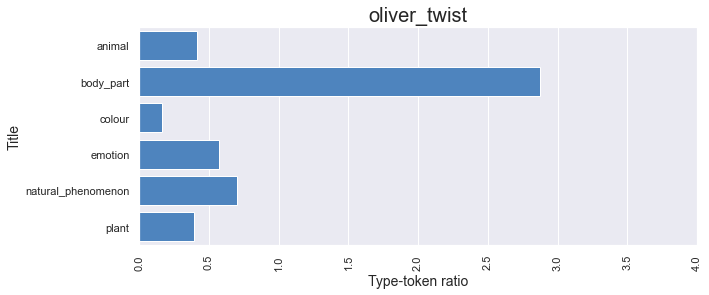



Most common emotions in "oliver_twist"

fear (69); love (53); alarm (30); happiness (28); fit (22); joy (17); terror (16); rage (15); horror (13); excitement (12); wrath (11); shudder (10); dread (9); hatred (9); hate (9); 

Most common colours in "oliver_twist"

black (31); red (27); green (25); blue (11); drab (8); sanguine (4); paleness (4); yellow (3); brown (3); crimson (2); tint (1); whiteness (1); gray (1); 

Most common body_parts in "oliver_twist"

hand (331); eye (264); head (242); back (242); face (212); small (92); arm (82); foot (77); shoulder (44); ear (43); lip (36); mouth (31); knee (29); nose (26); throat (24); 

Most common natural phenomena in "oliver_twist"

light (115); low (80); quiet (36); thrust (35); wind (28); drag (25); exchange (23); smoke (21); rain (18); interrupt (16); energy (12); deposit (10); cloud (9); gravity (9); bolt (8); 

Most common animals in "oliver_twist"

dog (91); bear (53); female (17); horse (17); fly (13); male (9); bird (9); mount (8)

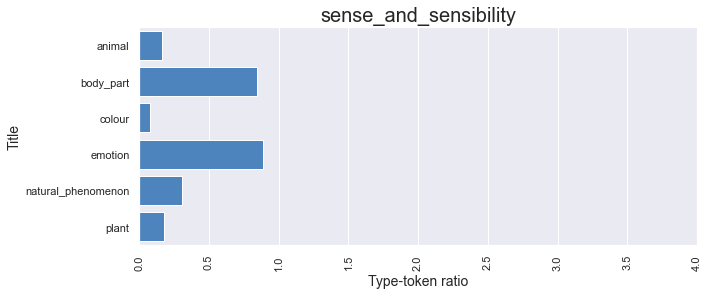



Most common emotions in "sense_and_sensibility"

love (93); happiness (65); fear (49); spite (35); joy (25); alarm (23); temper (16); fit (10); dread (10); uneasiness (9); indignation (9); resentment (8); horror (6); apprehension (6); suspense (6); 

Most common colours in "sense_and_sensibility"

complexion (9); red (6); gray (6); sanguine (5); green (3); crimson (2); black (2); brown (2); blue (1); paleness (1); pink (1); 

Most common body_parts in "sense_and_sensibility"

eye (77); hand (58); small (48); fanny (48); back (40); head (36); face (26); lip (10); ear (9); quick (8); arm (6); foot (5); cheek (5); shoulder (4); behind (4); 

Most common natural phenomena in "sense_and_sensibility"

low (27); quiet (19); weather (19); rain (13); light (12); attraction (9); wind (9); exchange (7); interrupt (7); gravity (5); energy (4); bond (4); mildness (3); cloud (3); reluctance (2); 

Most common animals in "sense_and_sensibility"

bear (34); horse (19); female (2); entire (2); rat (2

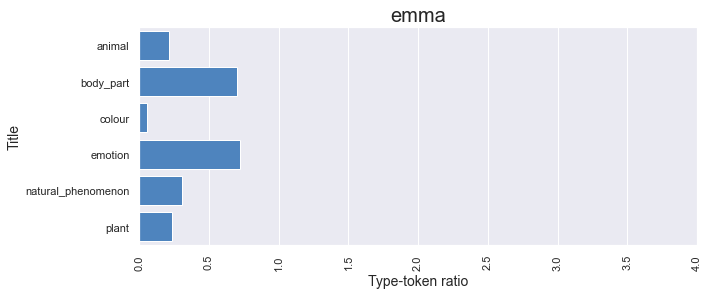



Most common emotions in "emma"

love (136); happiness (74); fear (35); alarm (29); temper (26); spite (24); joy (17); fit (15); dread (11); uneasiness (9); resentment (9); horror (9); anger (7); apprehension (7); indignation (7); 

Most common colours in "emma"

complexion (12); sanguine (7); black (5); blue (4); yellow (3); red (1); scarlet (1); green (1); brown (1); pink (1); coral (1); purple (1); 

Most common body_parts in "emma"

hand (78); eye (74); back (65); small (46); head (38); face (34); quick (24); arm (14); throat (10); foot (9); tongue (9); lip (7); brain (7); nerve (6); cheek (6); 

Most common natural phenomena in "emma"

weather (38); quiet (25); low (24); rain (21); snow (21); light (14); heat (10); attraction (9); interrupt (7); exchange (4); reluctance (3); energy (3); storm (3); cloud (3); candlelight (2); 

Most common animals in "emma"

bear (59); horse (30); female (9); fly (9); entire (8); cow (4); shark (4); mount (3); mare (2); stray (2); puppy (2); mule 

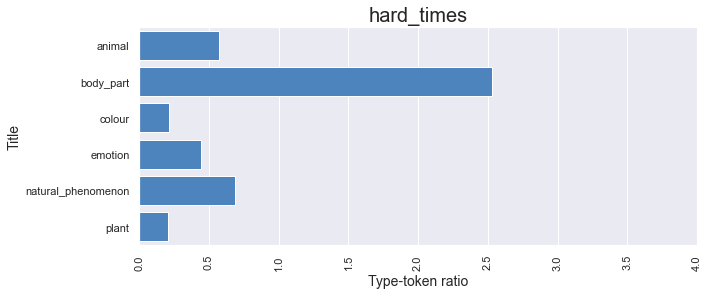



Most common emotions in "hard_times"

love (52); fear (25); fit (13); dread (10); hate (9); happiness (9); spite (7); anger (7); indignation (5); resentment (5); alarm (5); temper (4); shudder (4); suspense (4); quiver (3); 

Most common colours in "hard_times"

black (43); red (26); green (8); blue (6); gray (4); complexion (3); purple (2); sanguine (2); crimson (2); carmine (1); iron-grey (1); blackness (1); pink (1); 

Most common body_parts in "hard_times"

hand (194); face (166); eye (149); head (138); back (103); arm (52); foot (38); leg (28); small (28); lip (22); nose (17); mouth (17); shoulder (17); quick (16); forehead (15); 

Most common natural phenomena in "hard_times"

light (77); low (35); quiet (35); smoke (28); rain (20); wind (17); heat (12); weather (10); chop (5); interrupt (5); storm (4); drag (4); cloud (4); mist (3); dew (3); 

Most common animals in "hard_times"

whelp (42); dog (41); horse (37); bear (35); bird (8); female (8); cow (6); elephant (6); serpent 

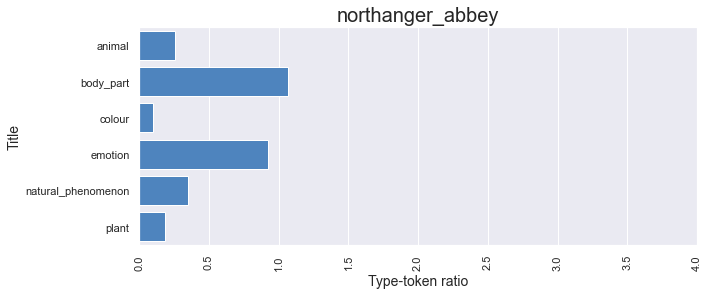



Most common emotions in "northanger_abbey"

love (59); happiness (37); alarm (29); fear (24); spite (15); dread (11); fit (10); resentment (9); horror (8); terror (8); joy (8); hate (7); temper (6); envy (6); uneasiness (6); 

Most common colours in "northanger_abbey"

black (9); green (6); complexion (5); yellow (3); ebony (3); blue (2); purple (2); gray (1); paleness (1); red (1); sanguine (1); 

Most common body_parts in "northanger_abbey"

eye (72); back (48); hand (44); head (34); small (33); arm (20); face (19); quick (11); chest (10); cheek (7); lip (6); ear (5); alas (5); lid (5); horseback (3); 

Most common natural phenomena in "northanger_abbey"

light (20); rain (17); wind (13); weather (10); quiet (9); low (8); exchange (5); ray (5); storm (5); gust (3); cloud (2); torrent (2); bolt (2); sunshine (2); attraction (2); 

Most common animals in "northanger_abbey"

horse (33); bear (12); female (11); fly (5); mount (3); entire (2); puppy (2); hereford (2); terrier (2); dog (

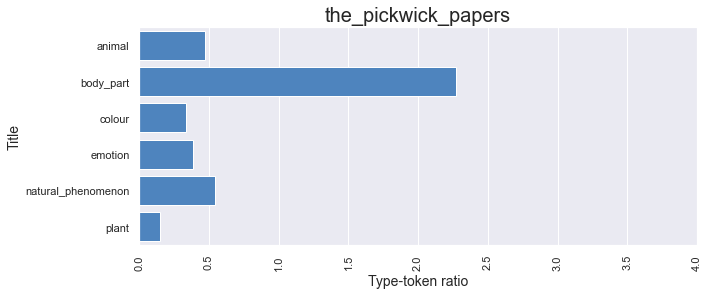



Most common emotions in "the_pickwick_papers"

love (55); fear (50); alarm (45); indignation (38); excitement (36); fit (34); happiness (34); joy (22); horror (19); rage (16); envy (15); wrath (14); gratification (14); terror (13); apprehension (12); 

Most common colours in "the_pickwick_papers"

black (105); blue (89); red (85); green (75); gray (34); brown (28); yellow (23); pink (16); crimson (14); drab (12); sky-blue (7); purple (6); complexion (5); tint (4); claret (3); 

Most common body_parts in "the_pickwick_papers"

hand (540); head (436); eye (414); face (310); back (275); small (164); arm (155); foot (107); trotter (92); leg (84); ear (65); nose (58); shoulder (56); lip (47); mouth (45); 

Most common natural phenomena in "the_pickwick_papers"

light (149); low (84); quiet (57); thrust (51); smoke (45); wind (36); drag (34); deposit (32); energy (30); interrupt (30); exchange (24); cloud (24); rain (21); bolt (19); gravity (18); 

Most common animals in "the_pickwick_pape

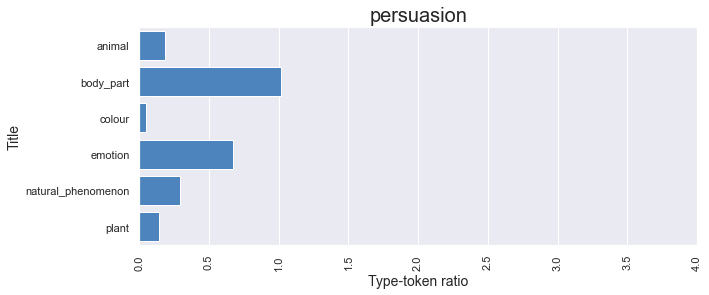



Most common emotions in "persuasion"

love (55); happiness (32); fear (16); fit (12); alarm (11); spite (11); temper (10); suspense (10); gratification (8); dread (8); horror (7); jealousy (6); apprehension (5); joy (5); hate (4); 

Most common colours in "persuasion"

black (5); complexion (4); sanguine (2); blue (2); red (2); brown (1); green (1); 

Most common body_parts in "persuasion"

back (69); eye (55); hand (44); head (40); small (31); face (25); arm (16); quick (9); nerve (9); foot (9); cheek (8); ala (4); fanny (4); mouth (3); behind (3); 

Most common natural phenomena in "persuasion"

low (19); quiet (16); rain (11); weather (10); light (8); attraction (7); interrupt (7); wind (4); storm (2); smoke (2); mildness (2); exchange (2); heat (2); cloud (2); gale (1); 

Most common animals in "persuasion"

bear (28); horse (13); asp (6); female (5); dog (3); fly (3); entire (2); rat (2); crow (1); male (1); sheep (1); mankind (1); sparrow (1); 

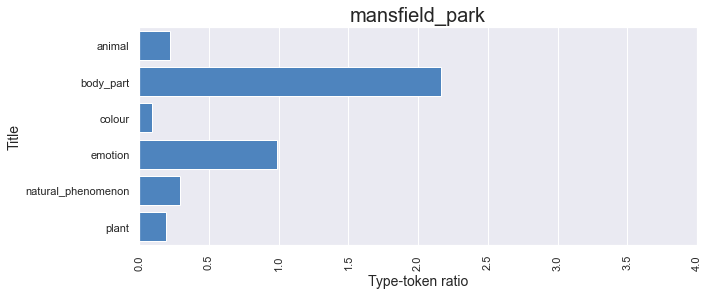



Most common emotions in "mansfield_park"

love (156); happiness (86); fear (59); spite (35); temper (33); alarm (32); fit (28); joy (17); vexation (16); anger (15); dread (14); jealousy (12); envy (12); displeasure (11); resentment (10); 

Most common colours in "mansfield_park"

sanguine (12); complexion (9); green (9); black (8); red (5); brown (3); blue (3); pink (3); scarlet (2); paleness (2); claret (1); crimson (1); purple (1); yellow (1); amber (1); 

Most common body_parts in "mansfield_park"

fanny (919); eye (91); hand (88); back (82); small (58); head (51); face (28); quick (20); arm (15); foot (11); nerve (7); lip (6); extremity (4); cheek (4); horseback (4); 

Most common natural phenomena in "mansfield_park"

quiet (30); light (30); low (24); weather (20); gravity (9); wind (9); interrupt (8); cloud (8); heat (7); reluctance (7); attraction (6); rain (6); exchange (4); energy (4); snow (3); 

Most common animals in "mansfield_park"

bear (42); horse (38); pheasant (9); 

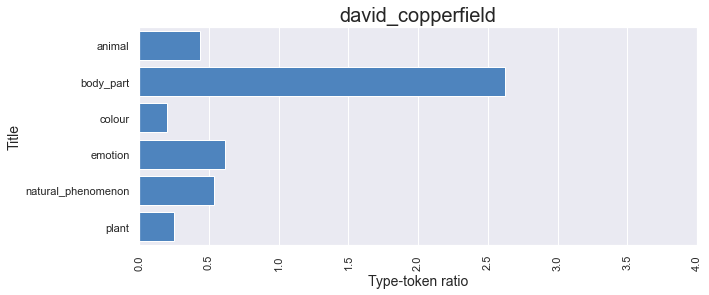



Most common emotions in "david_copperfield"

love (368); fear (60); happiness (55); fit (42); joy (41); dread (34); alarm (31); apprehension (29); excitement (18); spite (17); uneasiness (16); devotion (15); temper (14); indignation (12); horror (10); 

Most common colours in "david_copperfield"

black (77); red (71); blue (46); green (41); brown (19); complexion (9); sanguine (7); gray (7); yellow (6); fawn (5); pink (5); sky-blue (3); drab (2); scarlet (2); coral (1); 

Most common body_parts in "david_copperfield"

hand (723); head (505); face (473); eye (439); back (402); arm (220); foot (102); small (90); shoulder (76); lip (63); ear (55); leg (55); breast (54); chin (52); knee (48); 

Most common natural phenomena in "david_copperfield"

light (184); low (107); quiet (89); wind (60); smoke (31); cloud (27); weather (25); rain (19); snow (19); exchange (16); energy (15); heat (14); interrupt (14); storm (13); chop (12); 

Most common animals in "david_copperfield"

bear (121); h

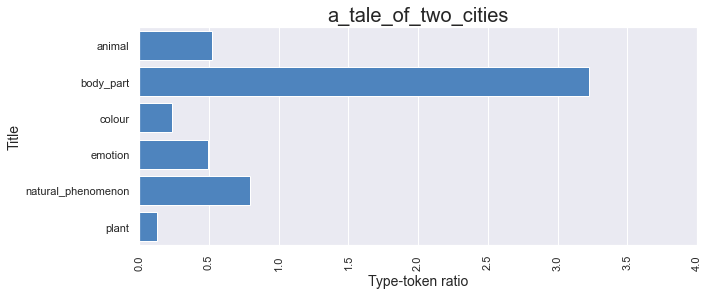



Most common emotions in "a_tale_of_two_cities"

love (76); fear (33); dread (20); fit (14); alarm (13); terror (12); happiness (12); horror (11); uneasiness (9); anger (7); apprehension (7); suspense (6); joy (5); shudder (4); furies (4); 

Most common colours in "a_tale_of_two_cities"

red (52); black (37); blue (18); brown (12); green (5); yellow (5); complexion (5); paleness (3); whiteness (2); crimson (2); claret (1); fawn (1); purple (1); sanguine (1); 

Most common body_parts in "a_tale_of_two_cities"

hand (373); face (242); head (213); eye (193); back (136); arm (122); foot (67); breast (55); finger (51); shoulder (49); small (43); lip (42); ear (29); mouth (25); quick (24); 

Most common natural phenomena in "a_tale_of_two_cities"

light (123); low (62); quiet (41); wind (28); smoke (21); rain (18); storm (17); mist (17); cloud (16); drag (11); weather (9); lightning (8); hail (7); ray (7); heat (7); 

Most common animals in "a_tale_of_two_cities"

horse (58); bear (48); dog

In [23]:
import warnings
warnings.filterwarnings("ignore")

def wordnet_hypernyms(token):
    all_hypernyms = []
    black_list = ['queen','young','human']
    
    if token not in black_list:
        
        word_senses = wn.synsets(token)

        hypernyms = lambda s: s.hypernyms()

        return_value = False

        for ws in word_senses:

            hypernyms = [hyp.name() for hyp in list(ws.closure(hypernyms))]

            if 'plant.n.02' in hypernyms:
                all_hypernyms.append('plant')
            if 'color.n.01' in hypernyms:
                all_hypernyms.append('colour')
            if 'emotion.n.01' in hypernyms:
                all_hypernyms.append('emotion')
            if 'animal.n.01' in hypernyms:
                all_hypernyms.append('animal')
            if 'natural_phenomenon.n.01' in hypernyms:
                all_hypernyms.append('natural_phenomenon')
            if 'body_part.n.01' in hypernyms:
                all_hypernyms.append('body_part')
                                    
    return all_hypernyms

for file in os.listdir(directory):
    
    if re.search( 'lemma.txt',file ):
        data = []
        
        key = os.path.join(directory,re.sub('_lemma','',file))
        title = find_title(key)
        path = os.path.join(directory,file)
        with open(path,encoding='utf') as fh:
            full_text = fh.read()
            words = word_tokenize(full_text.lower())
            words = clean_wordlist(words)
            freq = Counter(words)

            for word,count in freq.most_common():
                hypernyms = wordnet_hypernyms(word)
                if len(hypernyms)>0:
                    for h in hypernyms:
                        row = []
                        row.append(word)
                        row.append(h)
                        row.append(count)
                        data.append(row)
                        
        df = pd.DataFrame(data,columns=['word','domain','count'])
                        
                        

        x_axis = list(df.groupby('domain')['count'].sum().to_dict().values())
        # normalise values
        x_axis = [(value/nr_tokens[key])*100 for value in x_axis]
        y_axis = list(df.groupby('domain')['count'].sum().to_dict().keys())
                                
        colours = ['#599ad3','#f9a65a']

        fig = plt.figure( figsize=( 10,4 ) )

        graph = sns.barplot( x=x_axis, y=y_axis, 
                            color = '#3b83d1' )

        graph.set_title(title , size = 20) 
        graph.set_xlabel('Type-token ratio' , size = 14) 
        graph.set_ylabel('Title' , size = 14 )
        
        graph.set_xlim(0,4)


        plt.xticks(rotation= 90)

        plt.show()
        
        print(f'\n\nMost common emotions in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="emotion" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
                
        print(f'\n\nMost common colours in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="colour" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        print(f'\n\nMost common body_parts in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="body_part" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        
        print(f'\n\nMost common natural phenomena in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="natural_phenomenon" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
        
        print(f'\n\nMost common animals in "{find_title(key)}"\n')
        
        count = 0
        for i,row in df.query(' domain=="animal" ').sort_values(by='count',ascending=False).iterrows():
            print(f"{row['word']} ({row['count']})" , end= '; ' )
            count += 1
            if count==15:
                break
                

## Sentiment analysis

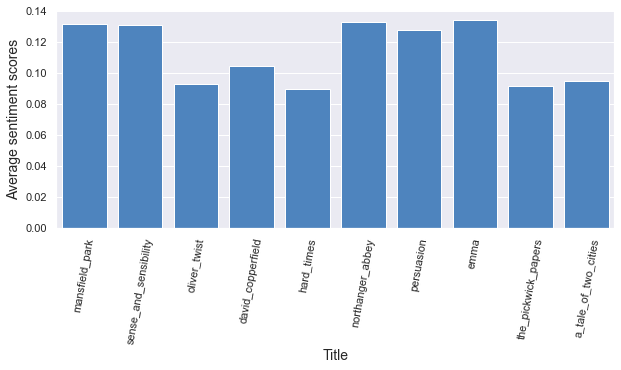

In [24]:

def average_score(file):
    all_scores = []
    file = open( file , encoding = 'utf-8' )
    full_text = file.read()
    sentences = sent_tokenize( full_text )
    for s in sentences:
        scores = ana.polarity_scores(s)
        all_scores.append( scores["pos"] )
    return sum(all_scores)/len(all_scores)
        
sent_scores = dict()

for text in corpus:

    avg_score = average_score(text)
    sent_scores[text]=avg_score
    
    
x_axis = list(sent_scores.keys())
y_axis = list(sent_scores.values())

x_axis = [find_title(text) for text in x_axis]

fig = plt.figure( figsize=( 10,4 ) )

graph = sns.barplot( x=x_axis, y=y_axis, 
                    color = '#3b83d1' )

#graph.set_title( '' , size = 20) 
graph.set_xlabel('Title' , size = 14 )
graph.set_ylabel('Average sentiment scores' , size = 14) 


plt.xticks(rotation= 80)

plt.show()